In [23]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from LSTM import *
from LSTMbis import *
import pandas as pd
import numpy as np
import torch.utils.data as utils
import time

import pdb

torch.manual_seed(1)

In [24]:
import os
data = {}
a=0
for j in range(1,7):
    for i in os.listdir('./new_data/%s'%j):
        if i.endswith('.txt'):
            a = a+1
            data['%s'%a] = pd.read_csv('new_data/{}/{}'.format(j,i), header = None, 
                                        names = ['frameNb','id', 'x','y','Vx','Vy'],
                                           delimiter=' ')

In [25]:
a = 0
inputs = np.zeros([len(data),14,2])
gt = np.zeros([len(data),6,2])
in_coord = np.zeros([len(data),14,2])
gt_coord = np.zeros([len(data),7,2])

for i in data:
    inputs[a,:,:] = np.array(data['%s'%i].loc[0:13,['Vx','Vy']])
    gt[a,:,:] = np.array(data['%s'%i].loc[14:19,['Vx','Vy']])
    in_coord[a,:,:] = np.array(data['%s'%i].loc[0:13,['x','y']])
    gt_coord[a,:,:] = np.array(data['%s'%i].loc[13:19,['x','y']])
    a +=1

In [21]:
mask = list(range(len(inputs)-100, len(inputs)))
x_val = inputs[mask]
y_val = gt[mask]
mask = list(range(len(inputs)-100))
x_train = inputs[mask]
y_train = gt[mask]

x_train,y_train = torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor)
x_val,y_val = torch.from_numpy(x_val).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.FloatTensor)

x_train = x_train.unsqueeze(1) # add 1 dimension to the training set
y_train = y_train.unsqueeze(1) # add 1 dimension to the training set
x_val = x_val.unsqueeze(1) # add 1 dimension to the validation set
y_val = y_val.unsqueeze(1) # add 1 dimension to the validation set

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)

traindataset = utils.TensorDataset(x_train, y_train)
trainloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

valdataset = utils.TensorDataset(x_val, y_val)
valloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

Train data shape:  torch.Size([4826, 1, 10, 2])
Train labels shape:  torch.Size([4826, 1, 10, 2])
Validation data shape:  torch.Size([100, 1, 10, 2])
Validation labels shape:  torch.Size([100, 1, 10, 2])


In [13]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=1, n_output=None):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv2d(n_input_channels,3,5,padding=2)
        self.conv1_bn = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
     
        self.fc1 = nn.Linear(10*2 * 3, 10*2 * 1)
        
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Variable `x` with `x.view`.                                                  #
        ################################################################################
        
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = x.view(-1, 10*2 * 3) # in order to reshape the tensor for as many columns we need
        x = self.fc1(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def predict(self, x):
        return self.forward(x)

In [14]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
epochs = 100
steps = 0
running_loss = 0
print_every = 100
vec_acc_ = np.zeros(epochs*25)
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Do not forget to transform the inputs and outputs into Variable        #
        # which pytorch uses.                                                          #
        ################################################################################
        inp = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        output = net.forward(inp)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        grad = loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            sum_accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                inp = Variable(images)
                targets = Variable(labels)
                predicted = net.predict(inp)
                accuracy = criterion(predicted, targets)
                accuracy = accuracy.data.numpy().tolist()[0]
                #vec_acc_[steps-1] = accuracy/(ii+1)
                sum_accuracy += accuracy
                
                #inputs = Variable(images, volatile=True)
                #predicted = net.predict(inputs)
                #equality = (labels == predicted.max(1)[1])
                #accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
                #im = Variable(images)
                #out = net.predict(im)
                #_,prediction = torch.max(out, 1)
                #pred_y = prediction.data.numpy().squeeze()
                #target_y = labels.numpy()
                #accuracy = np.mean(predicted == inputs)
                #print(pred_y.shape,target_y.shape)
                
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(loss.data[0]),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                  "steps {:.4f}".format(steps)
                 )
            running_loss = 0
            start = time.time()

#plt.plot(range(epochs*25),vec_acc_)
#plt.show()

Epoch: 1/100.. Loss: 0.4073.. 0.0005 s/batch  steps 100.0000
Epoch: 1/100.. Loss: 0.1746.. 0.0005 s/batch  steps 200.0000
Epoch: 1/100.. Loss: 0.2664.. 0.0005 s/batch  steps 300.0000
Epoch: 1/100.. Loss: 0.2650.. 0.0005 s/batch  steps 400.0000
Epoch: 1/100.. Loss: 0.2402.. 0.0005 s/batch  steps 500.0000
Epoch: 1/100.. Loss: 0.0355.. 0.0005 s/batch  steps 600.0000
Epoch: 1/100.. Loss: 0.1433.. 0.0005 s/batch  steps 700.0000
Epoch: 1/100.. Loss: 0.1376.. 0.0005 s/batch  steps 800.0000
Epoch: 1/100.. Loss: 0.0943.. 0.0004 s/batch  steps 900.0000
Epoch: 2/100.. Loss: 0.0739.. 0.0001 s/batch  steps 1000.0000
Epoch: 2/100.. Loss: 0.1446.. 0.0005 s/batch  steps 1100.0000
Epoch: 2/100.. Loss: 0.1013.. 0.0004 s/batch  steps 1200.0000
Epoch: 2/100.. Loss: 0.1761.. 0.0004 s/batch  steps 1300.0000
Epoch: 2/100.. Loss: 0.1148.. 0.0005 s/batch  steps 1400.0000
Epoch: 2/100.. Loss: 0.0959.. 0.0004 s/batch  steps 1500.0000
Epoch: 2/100.. Loss: 0.0443.. 0.0004 s/batch  steps 1600.0000
Epoch: 2/100.. Lo

Epoch: 14/100.. Loss: 0.0552.. 0.0005 s/batch  steps 13300.0000
Epoch: 14/100.. Loss: 0.0410.. 0.0005 s/batch  steps 13400.0000
Epoch: 14/100.. Loss: 0.0983.. 0.0005 s/batch  steps 13500.0000
Epoch: 15/100.. Loss: 0.1877.. 0.0004 s/batch  steps 13600.0000
Epoch: 15/100.. Loss: 0.0935.. 0.0005 s/batch  steps 13700.0000
Epoch: 15/100.. Loss: 0.1409.. 0.0005 s/batch  steps 13800.0000
Epoch: 15/100.. Loss: 0.0744.. 0.0005 s/batch  steps 13900.0000
Epoch: 15/100.. Loss: 0.0724.. 0.0005 s/batch  steps 14000.0000
Epoch: 15/100.. Loss: 0.0522.. 0.0005 s/batch  steps 14100.0000
Epoch: 15/100.. Loss: 0.0471.. 0.0005 s/batch  steps 14200.0000
Epoch: 15/100.. Loss: 0.0682.. 0.0005 s/batch  steps 14300.0000
Epoch: 15/100.. Loss: 0.0555.. 0.0005 s/batch  steps 14400.0000
Epoch: 16/100.. Loss: 0.0711.. 0.0001 s/batch  steps 14500.0000
Epoch: 16/100.. Loss: 0.1029.. 0.0005 s/batch  steps 14600.0000
Epoch: 16/100.. Loss: 0.0329.. 0.0006 s/batch  steps 14700.0000
Epoch: 16/100.. Loss: 0.0550.. 0.0005 s/

Epoch: 28/100.. Loss: 0.1074.. 0.0005 s/batch  steps 26200.0000
Epoch: 28/100.. Loss: 0.0373.. 0.0005 s/batch  steps 26300.0000
Epoch: 28/100.. Loss: 0.0546.. 0.0005 s/batch  steps 26400.0000
Epoch: 28/100.. Loss: 0.0500.. 0.0009 s/batch  steps 26500.0000
Epoch: 28/100.. Loss: 0.0719.. 0.0005 s/batch  steps 26600.0000
Epoch: 28/100.. Loss: 0.1335.. 0.0005 s/batch  steps 26700.0000
Epoch: 28/100.. Loss: 0.0413.. 0.0004 s/batch  steps 26800.0000
Epoch: 28/100.. Loss: 0.0778.. 0.0005 s/batch  steps 26900.0000
Epoch: 28/100.. Loss: 0.0383.. 0.0005 s/batch  steps 27000.0000
Epoch: 29/100.. Loss: 0.0282.. 0.0002 s/batch  steps 27100.0000
Epoch: 29/100.. Loss: 0.0424.. 0.0004 s/batch  steps 27200.0000
Epoch: 29/100.. Loss: 0.0647.. 0.0005 s/batch  steps 27300.0000
Epoch: 29/100.. Loss: 0.0563.. 0.0005 s/batch  steps 27400.0000
Epoch: 29/100.. Loss: 0.0692.. 0.0004 s/batch  steps 27500.0000
Epoch: 29/100.. Loss: 0.0250.. 0.0004 s/batch  steps 27600.0000
Epoch: 29/100.. Loss: 0.1064.. 0.0005 s/

Epoch: 41/100.. Loss: 0.0619.. 0.0005 s/batch  steps 39100.0000
Epoch: 41/100.. Loss: 0.0381.. 0.0004 s/batch  steps 39200.0000
Epoch: 41/100.. Loss: 0.0929.. 0.0005 s/batch  steps 39300.0000
Epoch: 41/100.. Loss: 0.2221.. 0.0005 s/batch  steps 39400.0000
Epoch: 41/100.. Loss: 0.0377.. 0.0005 s/batch  steps 39500.0000
Epoch: 41/100.. Loss: 0.0617.. 0.0005 s/batch  steps 39600.0000
Epoch: 42/100.. Loss: 0.0271.. 0.0004 s/batch  steps 39700.0000
Epoch: 42/100.. Loss: 0.0511.. 0.0005 s/batch  steps 39800.0000
Epoch: 42/100.. Loss: 0.1483.. 0.0005 s/batch  steps 39900.0000
Epoch: 42/100.. Loss: 0.0853.. 0.0004 s/batch  steps 40000.0000
Epoch: 42/100.. Loss: 0.0507.. 0.0004 s/batch  steps 40100.0000
Epoch: 42/100.. Loss: 0.0144.. 0.0005 s/batch  steps 40200.0000
Epoch: 42/100.. Loss: 0.1023.. 0.0004 s/batch  steps 40300.0000
Epoch: 42/100.. Loss: 0.0212.. 0.0005 s/batch  steps 40400.0000
Epoch: 42/100.. Loss: 0.0108.. 0.0005 s/batch  steps 40500.0000
Epoch: 43/100.. Loss: 0.0221.. 0.0001 s/

Epoch: 54/100.. Loss: 0.0708.. 0.0005 s/batch  steps 52000.0000
Epoch: 54/100.. Loss: 0.0490.. 0.0005 s/batch  steps 52100.0000
Epoch: 55/100.. Loss: 0.1345.. 0.0002 s/batch  steps 52200.0000
Epoch: 55/100.. Loss: 0.0593.. 0.0005 s/batch  steps 52300.0000
Epoch: 55/100.. Loss: 0.0659.. 0.0005 s/batch  steps 52400.0000
Epoch: 55/100.. Loss: 0.0175.. 0.0005 s/batch  steps 52500.0000
Epoch: 55/100.. Loss: 0.0540.. 0.0005 s/batch  steps 52600.0000
Epoch: 55/100.. Loss: 0.0518.. 0.0006 s/batch  steps 52700.0000
Epoch: 55/100.. Loss: 0.0400.. 0.0005 s/batch  steps 52800.0000
Epoch: 55/100.. Loss: 0.1225.. 0.0005 s/batch  steps 52900.0000
Epoch: 55/100.. Loss: 0.0780.. 0.0004 s/batch  steps 53000.0000
Epoch: 55/100.. Loss: 0.0408.. 0.0005 s/batch  steps 53100.0000
Epoch: 56/100.. Loss: 0.1752.. 0.0003 s/batch  steps 53200.0000
Epoch: 56/100.. Loss: 0.0671.. 0.0004 s/batch  steps 53300.0000
Epoch: 56/100.. Loss: 0.0671.. 0.0004 s/batch  steps 53400.0000
Epoch: 56/100.. Loss: 0.1271.. 0.0004 s/

Epoch: 68/100.. Loss: 0.0404.. 0.0008 s/batch  steps 64900.0000
Epoch: 68/100.. Loss: 0.0441.. 0.0005 s/batch  steps 65000.0000
Epoch: 68/100.. Loss: 0.0985.. 0.0005 s/batch  steps 65100.0000
Epoch: 68/100.. Loss: 0.1208.. 0.0005 s/batch  steps 65200.0000
Epoch: 68/100.. Loss: 0.0742.. 0.0009 s/batch  steps 65300.0000
Epoch: 68/100.. Loss: 0.1103.. 0.0008 s/batch  steps 65400.0000
Epoch: 68/100.. Loss: 0.0433.. 0.0005 s/batch  steps 65500.0000
Epoch: 68/100.. Loss: 0.1018.. 0.0005 s/batch  steps 65600.0000
Epoch: 69/100.. Loss: 0.0939.. 0.0001 s/batch  steps 65700.0000
Epoch: 69/100.. Loss: 0.0488.. 0.0005 s/batch  steps 65800.0000
Epoch: 69/100.. Loss: 0.0225.. 0.0005 s/batch  steps 65900.0000
Epoch: 69/100.. Loss: 0.0734.. 0.0005 s/batch  steps 66000.0000
Epoch: 69/100.. Loss: 0.0737.. 0.0006 s/batch  steps 66100.0000
Epoch: 69/100.. Loss: 0.0314.. 0.0005 s/batch  steps 66200.0000
Epoch: 69/100.. Loss: 0.0160.. 0.0005 s/batch  steps 66300.0000
Epoch: 69/100.. Loss: 0.0323.. 0.0005 s/

Epoch: 81/100.. Loss: 0.0313.. 0.0009 s/batch  steps 77800.0000
Epoch: 81/100.. Loss: 0.2418.. 0.0006 s/batch  steps 77900.0000
Epoch: 81/100.. Loss: 0.0276.. 0.0006 s/batch  steps 78000.0000
Epoch: 81/100.. Loss: 0.1359.. 0.0006 s/batch  steps 78100.0000
Epoch: 81/100.. Loss: 0.0737.. 0.0006 s/batch  steps 78200.0000
Epoch: 82/100.. Loss: 0.1190.. 0.0003 s/batch  steps 78300.0000
Epoch: 82/100.. Loss: 0.0233.. 0.0006 s/batch  steps 78400.0000
Epoch: 82/100.. Loss: 0.0616.. 0.0007 s/batch  steps 78500.0000
Epoch: 82/100.. Loss: 0.1137.. 0.0006 s/batch  steps 78600.0000
Epoch: 82/100.. Loss: 0.1163.. 0.0006 s/batch  steps 78700.0000
Epoch: 82/100.. Loss: 0.0344.. 0.0007 s/batch  steps 78800.0000
Epoch: 82/100.. Loss: 0.0732.. 0.0006 s/batch  steps 78900.0000
Epoch: 82/100.. Loss: 0.0130.. 0.0007 s/batch  steps 79000.0000
Epoch: 82/100.. Loss: 0.0347.. 0.0006 s/batch  steps 79100.0000
Epoch: 82/100.. Loss: 0.0635.. 0.0006 s/batch  steps 79200.0000
Epoch: 83/100.. Loss: 0.0945.. 0.0005 s/

Epoch: 94/100.. Loss: 0.0534.. 0.0005 s/batch  steps 90700.0000
Epoch: 94/100.. Loss: 0.0293.. 0.0005 s/batch  steps 90800.0000
Epoch: 95/100.. Loss: 0.1454.. 0.0005 s/batch  steps 90900.0000
Epoch: 95/100.. Loss: 0.0469.. 0.0005 s/batch  steps 91000.0000
Epoch: 95/100.. Loss: 0.0690.. 0.0005 s/batch  steps 91100.0000
Epoch: 95/100.. Loss: 0.0922.. 0.0005 s/batch  steps 91200.0000
Epoch: 95/100.. Loss: 0.1126.. 0.0007 s/batch  steps 91300.0000
Epoch: 95/100.. Loss: 0.0072.. 0.0006 s/batch  steps 91400.0000
Epoch: 95/100.. Loss: 0.0533.. 0.0006 s/batch  steps 91500.0000
Epoch: 95/100.. Loss: 0.0293.. 0.0007 s/batch  steps 91600.0000
Epoch: 95/100.. Loss: 0.0688.. 0.0006 s/batch  steps 91700.0000
Epoch: 96/100.. Loss: 0.1369.. 0.0002 s/batch  steps 91800.0000
Epoch: 96/100.. Loss: 0.0391.. 0.0006 s/batch  steps 91900.0000
Epoch: 96/100.. Loss: 0.0691.. 0.0006 s/batch  steps 92000.0000
Epoch: 96/100.. Loss: 0.0266.. 0.0009 s/batch  steps 92100.0000
Epoch: 96/100.. Loss: 0.0461.. 0.0008 s/

In [15]:
output_final = net.predict(Variable(x_train))
output_final = output_final.data.numpy()
output_final = np.reshape(output_final,(4826,10,2))
output_final.shape

(4826, 10, 2)

In [16]:
output_coord=np.zeros([11,len(output_final),2])
output_coord=np.zeros([len(output_final),11,2])
for j in range(11):
    for i in range(len(output_final)):
        if j==0:
            output_coord[i,j,:] = in_coord[i,9,:]
        else:
            output_coord[i,j,:] = output_coord[i,j-1,:]+output_final[i,j-1,:]*0.4


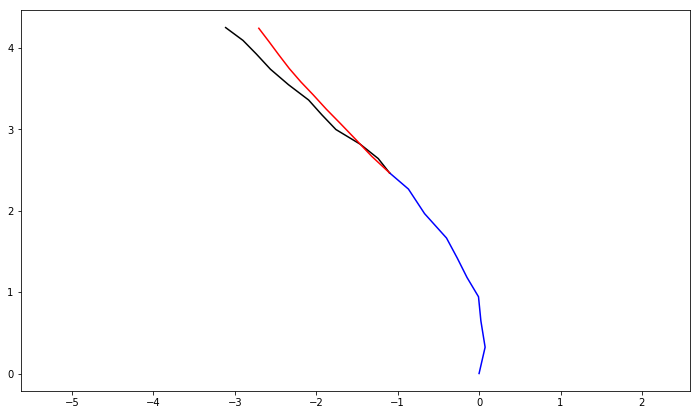

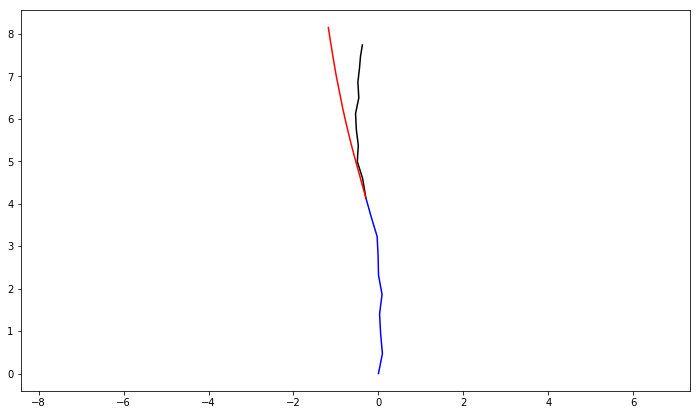

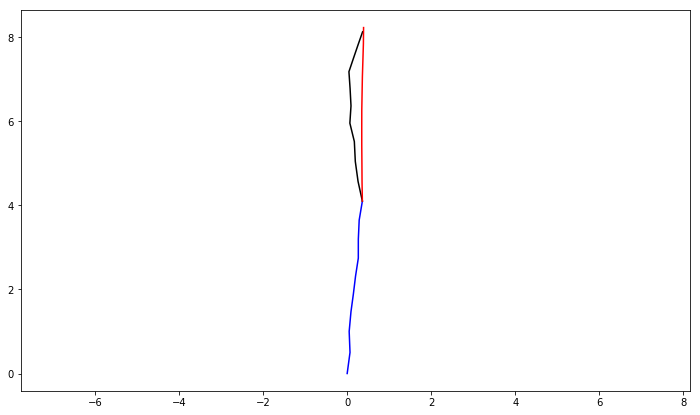

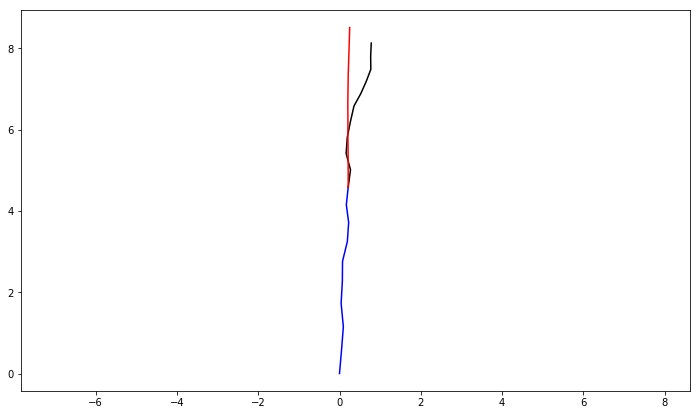

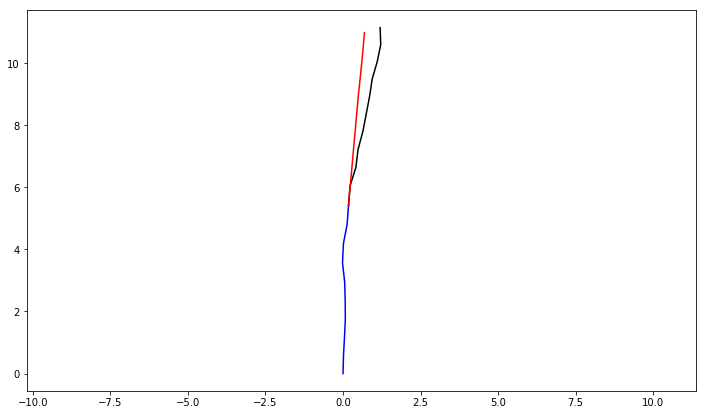

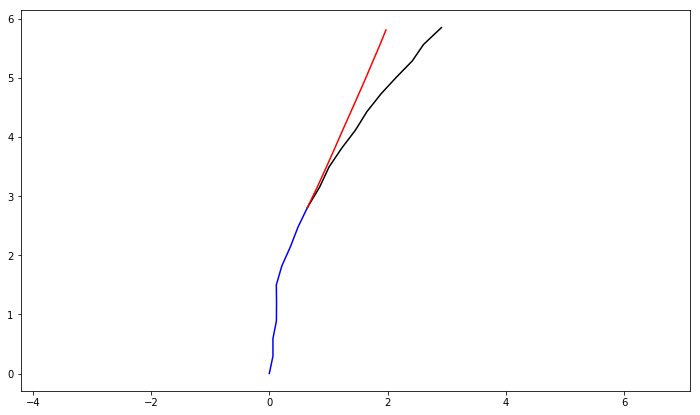

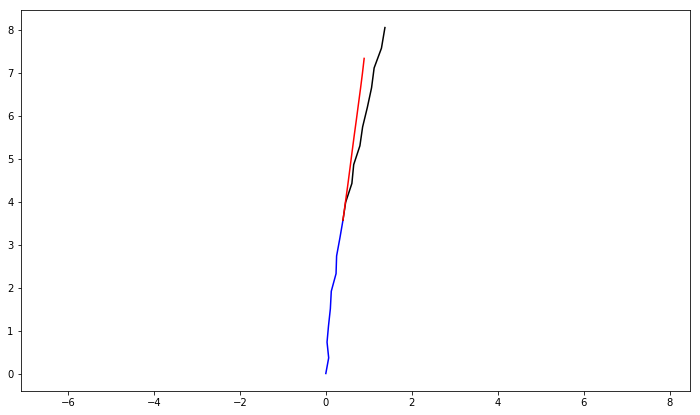

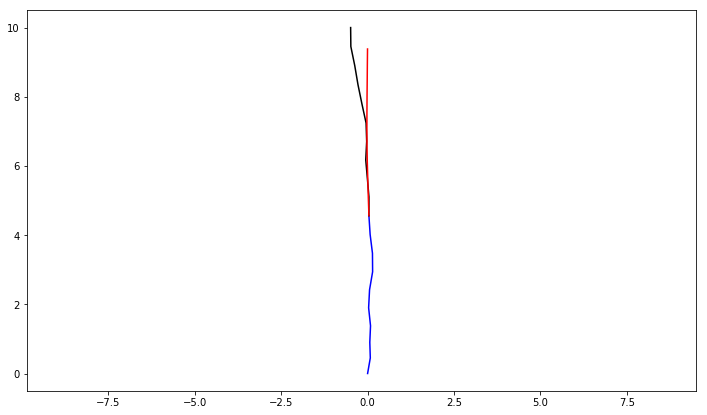

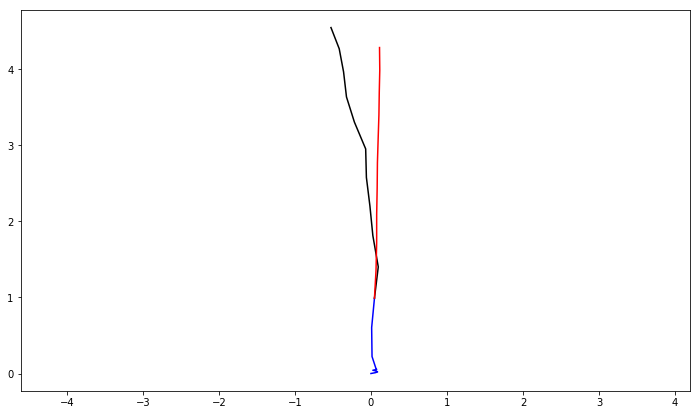

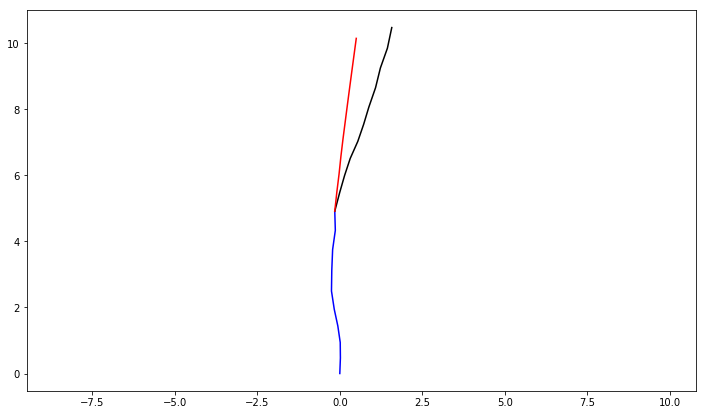

In [17]:
for i in range(10):
    plt.figure(figsize=(12, 7))

    plt.plot(in_coord[(i*20)+2000,:,0],in_coord[(i*20)+2000,:,1],c='b')
    plt.plot(gt_coord[(i*20)+2000,:,0],gt_coord[(i*20)+2000,:,1],c='k')
    plt.plot(output_coord[(i*20)+2000,:,0],output_coord[(i*20)+2000,:,1],c='r')
    plt.axis('equal')
    plt.show()